# <center>Using Random Forest with Proportional Subsetting for Time Series Forecasting</center>

## <center>Adarsh Nagar (adarshnagar@ucsb.edu), Brooks Piper</center>

## <center>March 25, 2025</center>

## Abstract

This project explores an alternative approach to time series forecasting by leveraging the Random Forest machine learning algorithm, specifically examining its performance when trained on varying proportions of lagged data. By comparing its predictive accuracy against established methodologies such as Box-Jenkins and Auto ARIMA, we find that Random Forest models trained on smaller lagged proportions, particularly 5% and 10%, exhibit superior performance. These findings establish the importance of challenging traditional assumptions about time series modeling and also highlight the evolving landscape of predictive analytics, where machine learning techniques continue to refine and enhance forecasting accuracy.

## 1. Introduction

As the ever-changing landscape of the technology market in one of the most capitally-affluent nations begins to grow at rapid speeds beyond comprehension, the world watches and admires in how previous barriers to growth are almost immediately traversed with the ingenuity of emerging topics within machine learning, AI, and big data processes. However, among the many existing challenges within the market, the inability to accurately forecast and predict trends across multiple different latitudes have left high-level researchers and quantitative developers with numerous unanswered questions and temporary solutions. Within this intersection of statistical modeling and machine learning, time series modeling allows users to model a time-correlated process and explore the impact of one of the most elusive, impactful predictors of any model, time itself. For the majority of the discipline's existence, stochastic models have dominated the methodology. Primarily, these include ARIMA and SARIMA models, which model the influence of previous time points on current data. While robust to many troublesome patterns found within the average time series, their performative ability begins to decline with greater data complexity. Furthermore, parametric models, while accurate and reliable in their ideal conditions, always suffer from violated assumptions in modern-day applications. Among these violations is the lack of homoskedasticity, which plagued models with inconsistent variance until Robert F. Engle's ARCH model $_{[1]}$ was born to combat its detrimental influence by building upon autoregressive models by introducing squared terms. 

Like Engle, other researchers strive to address these challenges through innovative approaches. As advancements in predictive modeling continue to evolve, we turn our attention to the 2017 study by Hristos Tyralis and Georgia Papacharalampous $_{[2]}$, which demonstrates the superior predictive performance of Random Forest models trained on proportions of lagged data.

In order to advance our understanding of this topic, we will be expanding upon this study, utilizing the methodology of Tyralis and Papacharalampous to inspire our investigation into the effectiveness of Random Forest-engineered time series models in comparison to other contemporary methods. In addition to performing comparative measures of accuracy, we will be focusing our attention towards the unique attributes of the examined BCG Jena Weather Station Dataset from 2017-2024 $_{[3]}$, confronting the potential drawbacks from larger datasets with demonstrated seasonality.

## 2. Data Processing

In [345]:
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

path = kagglehub.dataset_download("matthewjansen/bgc-jena-weather-station-dataset-20172024")
files = os.listdir(path)
csv_file = [file for file in files if file.endswith('.csv')]
dataset_path = os.path.join(path, csv_file[0])
df = pd.read_csv(dataset_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
0,2017-01-01 00:10:00,999.77,-4.91,268.27,-8.41,76.3,4.24,3.23,1.00,2.01,...,0.78,1.56,184.0,0.0,0.0,0.0,0.0,0.0,7.10,434.3
1,2017-01-01 00:20:00,999.63,-5.05,268.13,-8.37,77.4,4.19,3.24,0.95,2.02,...,1.52,1.92,202.6,0.0,0.0,0.0,0.0,0.0,7.72,434.1
2,2017-01-01 00:30:00,999.54,-4.98,268.21,-8.38,76.9,4.21,3.24,0.97,2.02,...,0.98,1.78,227.4,0.0,0.0,0.0,0.0,0.0,8.77,430.4
3,2017-01-01 00:40:00,999.40,-4.88,268.33,-8.56,75.2,4.25,3.19,1.05,1.99,...,1.16,1.80,212.5,0.0,0.0,0.0,0.0,0.0,9.36,430.6
4,2017-01-01 00:50:00,999.17,-5.17,268.06,-8.74,75.8,4.15,3.15,1.01,1.96,...,1.50,2.64,222.1,0.0,0.0,0.0,0.0,0.0,9.45,429.5


The BCG Jena Weather Station Dataset is a comprehensive collection of weather-related observations, specifically contains 22 measurements of weather related processes such as pressure, temperature, and namely, rainfall. In this project, we will be focusing on the rain measurements and exploring the predictive influence of previous time lags within the dataset. As collectively exhaustive and informative it may be to predicate our models upon the given 10 minute intervals of data from January 1, 2017, to December 31, 2024, (totalling over 400,000 data points) we will be converting to monthly averages in order to reduce the computational expense of our calculations and potential overfitting with the unnecessary collection of insignificant white noise at higher frequencies. The transformed time series is plotted below.

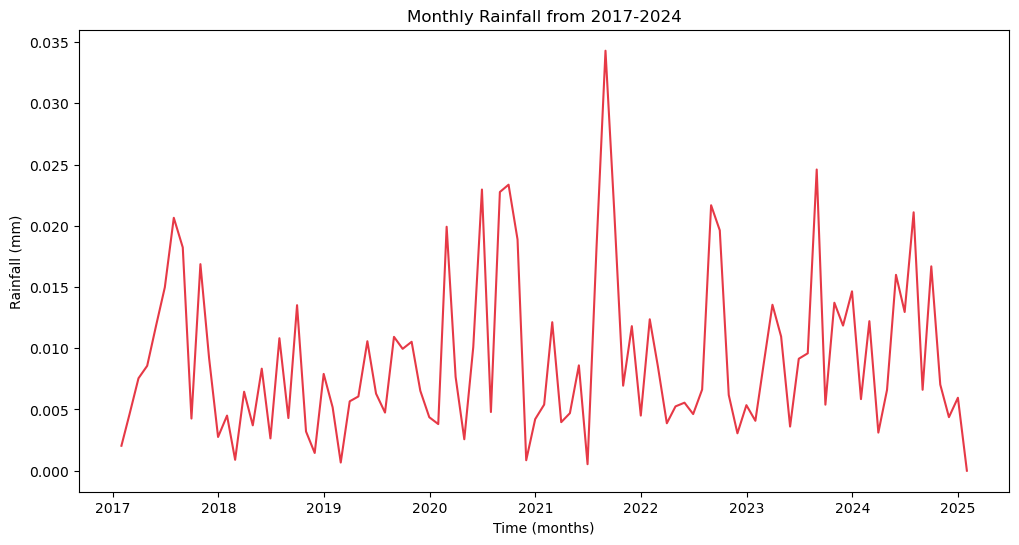

In [346]:
df = df[["Date Time", "rain (mm)"]]
df["datetime"] = pd.to_datetime(df["Date Time"])
df.set_index("datetime", inplace=True)
df = df["rain (mm)"].resample("ME").mean().to_frame(name="Rainfall")

plt.figure(figsize=(12, 6))
plt.plot(df, color="#E63946")
plt.xlabel("Time (months)")
plt.ylabel("Rainfall (mm)")
plt.title("Monthly Rainfall from 2017-2024")
plt.show()

## 3. Fitting Time Series Models

### Methodologies Preview:

- ##### Random Forest (Machine Learning)
- ##### ARIMA
- ##### SARIMAX
- ##### Auto ARIMA

### 3.1 Training-Testing Split

We will now partition the data into training and testing sets, with the cutoff set at the beginning of the final 12 months. This approach enables a direct comparison of various predictive models and their accuracy relative to the true data. The following visualization captures the training-testing split.

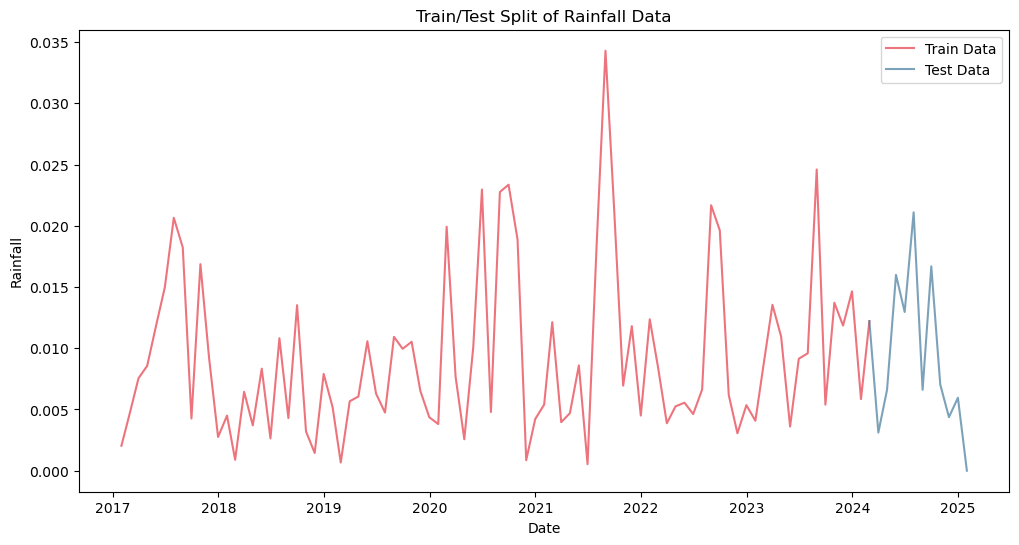

In [347]:
split_date = df.index[-12]

df_train = df.loc[:split_date]
df_test = df.loc[split_date:]

X_train, y_train = df_train.drop(columns=["Rainfall"]), df_train["Rainfall"]
X_test, y_test = df_test.drop(columns=["Rainfall"]), df_test["Rainfall"]

forecast_start = y_test.index[0]
forecast_end = y_test.index[-1]

train_index = y_train.index
test_index = y_test.index

plt.figure(figsize=(12, 6))
plt.plot(train_index, y_train, label="Train Data", color="#E63946", alpha=0.7)
plt.plot(test_index, y_test, label="Test Data", color="#457B9D", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.title("Train/Test Split of Rainfall Data")
plt.legend()
plt.show()

### 3.2 Random Forest Method

For the first method in our analysis, we recreate the results of Tyralis and Papacharalampous. The code below features two functions: *create_lagged_features()* and *rf_predictor()*. The first of the two creates lagged vectors for the Random Forest model to regress on to. For example, since our training data has 97 observations, the data frame includes the original rainfall measurements with an additional 97 columns with data lagged at $h=1,h=2,\cdots,h=97$. Finally, the function outputs the new data frame.

The second of the two functions performs the predictions using Random Forest. After running the *create_lagged_features()* function, *rf_predictor()* fits many different Random Forests with a specific proportion of the lagged columns. These proportions range from 0.05 to 0.5, with 0.05 increments. Tyralis and Papacharalampous suggest using 500 trees for the Random Forest models as a medium between Kuhn and Johnson $_{[4]}$, and Probst and Boulesteix $_{[5]}$, who suggest 1000 and 100 trees, respectively. Within each proportional fitting, the function identifies predictors with importance. We have selected the cutoff to have *any* importance (i.e. above 0). A new Random Forest is then fit with only important predictors. After all Random Forests are fitted, the function outputs a numpy array with the predictions from every iteration. One can easily extract the predictions from each iteration by slicing the array at increments of 12 (our forecast period).

In [348]:
def create_lagged_features(lags):
    for lag in range(1, lags + 1):
        df[f"lag_{lag}"] = df["Rainfall"].shift(lag)
    return df

def rf_predictor(df):
    n1 = len(df)
    nfit = n1 - 1  
    
    test_df = create_lagged_features(nfit)
    rf = RandomForestRegressor(n_estimators=500, random_state=1)
    
    predictions = []
    
    for proportion in [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]:
        num_lags = int(proportion * nfit)
        train_df = create_lagged_features(num_lags)
        
        X_train = train_df.drop(columns=["Rainfall"])
        y_train = train_df["Rainfall"]
        
        rf.fit(X_train, y_train)
        
        X_test = test_df.drop(columns=["Rainfall"])
        
        result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=1)
        importance = result.importances_mean
        important_lags = np.where(importance > 0)[0]
        
        important_train_df = X_train.iloc[:, important_lags]
        rf.fit(important_train_df, y_train)
        
        X_test_imp = X_test.iloc[:, important_lags]
        pred_imp = rf.predict(X_test_imp)
        predictions.append(pred_imp)
    
    predictions = np.concatenate(predictions)
    return predictions

rf_pred = rf_predictor(y_train)

### 3.3 Box-Jenkins Method

For the second method, we fit several ARIMA and SARIMA models using the Box-Jenkins methodology. Furthermore, in examining the ACF and PACF plots to identify model components at the discretion of the viewer, fitting several candidate models, and harnessing AIC to source the best model, Box-Jenkins will remain the most manual approach to weather forecasting in this entire study. Accordingly, we will be using the ACF and PACF to judge stationarity from a glance before using our judgement to fit models, which inherently produces model diagnostics in table format post-fitting procedures. 

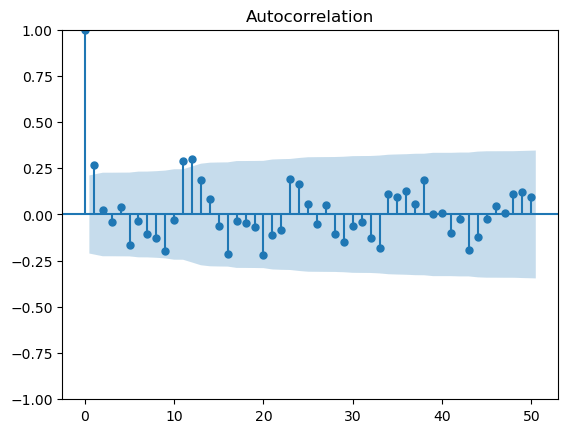

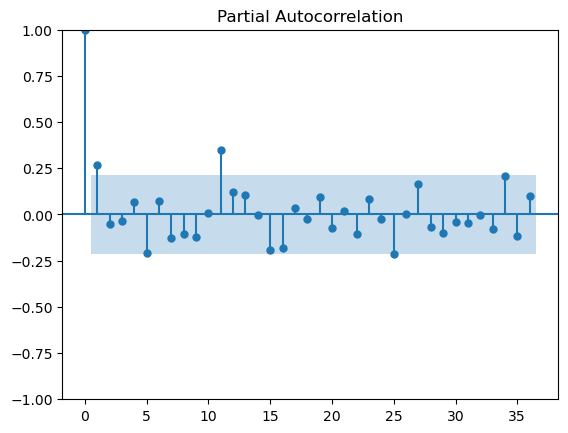

In [349]:
acf_vals = plot_acf(y_train, lags=50)
pacf_vals = plot_pacf(y_train, lags=36)

#### 3.3.1 ACF and PACF Analysis

In an effort to provide equal evaluation of the entire dataset, the above PACF and ACF plots cover the farthest possible range of previous lags in order to evaluate their statistical influence on the latest rainfall metric of the training set. In the assessment of stationarity, our extension of the lag bounds allow us to verify the stationarity and potential seasonality of our data's periodicity. Within this regard, we acknowledge the stationarity of our data with the evident majority of our data residing within the mildly-transparent confidence interval of stationary justification. Thus, our analyses have yielded the following considerations in our ARIMA model-fitting procedures:

- ACF-deduced Autoregressive (AR): 1 or 0
- Differencing (I): 0
- PACF-deduced Moving Average (MA): 1 or 0


However, within these bounds, there appear to be seasonal fluctuations with rainfall influence. Directly attributing this to known weather patterns of rainfall between Spring, Summer, Fall, and Winter of the 7 year examination, we will be incorporating a seasonal autoregressive integrated moving average (SARIMAX, with X indicating accountancy for potential exogenous influence) model in addition to our standard ARIMA models to account for potential underlying model violations in heteroskedasticity/trend stationarity. With an end goal of comparing identically-scaled MSEs across differing predictive algorithms, we will refrain from transformations in order to intentionally measure which algorithm captures the most seasonally-complex trends under identical conditions. 

In [350]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

# ARIMA Fitting: 
bj_ma_model = ARIMA(y_train, order=(0, 0, 1))
bj_ar_model = ARIMA(y_train, order=(1, 0, 0))
bj_arma_model = ARIMA(y_train, order=(1, 0, 1))

print(bj_ma_model.fit().summary())
print(bj_ar_model.fit().summary())
print(bj_arma_model.fit().summary())


# SARIMA Fitting:
sbj_ma_model = ARIMA(y_train, order=(0,0,1), seasonal_order=(1,0,1,12)) # best model
sbj_ar_model = ARIMA(y_train, order=(1,0,0), seasonal_order=(1,0,1,12))
sbj_arma_model = ARIMA(y_train, order=(1,0,1), seasonal_order=(1,0,1,12))

print(sbj_ma_model.fit().summary())
print(sbj_ar_model.fit().summary())
print(sbj_arma_model.fit().summary())

# For future predictions
bj_pred = sbj_ma_model.fit().predict(start=forecast_start,end=forecast_end)

                               SARIMAX Results                                
Dep. Variable:               Rainfall   No. Observations:                   86
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 312.457
Date:                Fri, 21 Mar 2025   AIC                           -618.915
Time:                        14:32:21   BIC                           -611.552
Sample:                    01-31-2017   HQIC                          -615.951
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0092      0.001      8.343      0.000       0.007       0.011
ma.L1          0.2755      0.082      3.367      0.001       0.115       0.436
sigma2      4.086e-05   6.78e-06      6.028      0.0

As expected, our results' accuracy vary heavily with gaps of differing significance in each model. Within our examination of the simpler ARIMA models, a lack of statistical significance from our Jarque-Bera Statistics and Ljung-Box Q-Statistics reveal unreliability in the trends captured. However, as we examine the statistical significance of more complex models accounting for seasonality across periods of 12 months, we grasp trend statistics with greater reliability in forecasting capacity. Specifically, while the SARIMA(1,0,1)$\times$(1,0,1)$_{12}$ model lacks statistical significance across multiple underlying assumptions, SARIMA(1,0,0)$\times$(1,0,1)$_{12}$ and SARIMA(0,0,1)$\times$(1,0,1)$_{12}$ retain statistically significant deductions, with a slightly greater edge in accuracy in the latter model observed from AIC. Inspecting the exact conditions of optimality: 

- Ljung Box Statistic (Q) = 0.03: When ${p=0.87}$, we are able to confirm there is no autocorrelation among the residuals
- Heteroskedasticity (H) = 0.86: When ${p=0.69}$, we are able to confirm the lack of heterskedasticity in our data.
- Jarque Bera(JB) = 11.14: When ${p=0.00}$, this statistic indicates the potential confounding presence of non-normality. However, due to the well-behaved residuals, this will only be a slight drawback to forecasts.
- AIC = -621.365: With the lowest AIC, this model will produce the most accurate predictions.


Albeit, a manually-conceived estimation with potential error, we will be using the SARIMA(0,0,1)$\times$(1,0,1)$_{12}$ as our ideal candidate, proceeding to use its "N-Steps Ahead" prediction as a comparative metric later in our study.

### 3.4 Auto Arima Method 

As our third and final method, we fit an Auto ARIMA model. While Auto ARIMA is widely regarded as highly inconsistent and unpredictable in its autonomous coefficient-selection process, its convenience in comparing a wide range of models allows us to find a reasonable-fitting model within a fraction of the time dedicated to manually-estimating in Box-Jenkins. Our parameter selection reasoning can be confined to the following:

- seasonal = True: confirming the presence of seasonality in our data
- trace = False: hiding pre-model processing for the sake of readability
- suppress_warnings = True: hiding warnings for greater readability
- stepwise=True: As it can be very computationally expensive in fully-evaluating every potential permutational (p,d,q)$\times$(P,D,Q)$_\text{s}$ sequence, we apply a stepwise search algorithm, reducing the search time with compromised "greediness" in a smaller possible statespace of evaluated models.
- information_criterion = 'aic': a selection indicating our benchmarking with the Aikage Information Criterion (AIC) metric for comparison
- random_state = 1: setting a seed across our simulation to create consistently comparable results for reproducability

In [351]:
# AUTO ARIMA Coding Module
from pmdarima import auto_arima

## Model-Fitting Procedures
monthly_model = auto_arima(
    y_train,
    seasonal = True,
    trace = False,
    suppress_warnings = True,
    stepwise = True,
    stationary = True,
    information_criterion = 'aic', 
    random_state = 1
    )

print("Test 1: Monthly Model Summary")
print(monthly_model.summary())
print("\n")

## Forecasting 
auto_arima_pred = monthly_model.predict(n_periods=len(y_test))

Test 1: Monthly Model Summary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   86
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 312.493
Date:                Fri, 21 Mar 2025   AIC                           -618.986
Time:                        14:32:22   BIC                           -611.623
Sample:                    01-31-2017   HQIC                          -616.022
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0068      0.001      4.803      0.000       0.004       0.010
ar.L1          0.2685      0.099      2.724      0.006       0.075       0.462
sigma2      4.082e-05 

Upon calculation and model comparison, the Auto ARIMA has yielded the aformentioned SARIMAX(1,0,0) model, which has an integrate accountancy for exogenous variables, which in this case would keep seasonality and additional confounding influences in consideration. Analyzing the diagnostics, our Auto ARIMA model brings a mixed bag filled with great statistical promise and minor potential gaps. Rather, investigating the diagnostics of our model's table above, we see as how our model's strength resides in its low AIC, high log-likelihood, normally-attributed Ljung-Box Statistics, and Homoscedasticity, further justifying its strong fit. However, in examining the potential drawbacks we inspect the Jarque-Bera Test, which indicates a statistically significant result and potentially non-normally distributed residuals. Thus, while the Auto ARIMA model may have a fairly strong model fit, the potential weakness in its residuals may allow for the presence of non-linear effects in our data. Furthermore, we will be comparing this directly to our SARIMAX from Box-Jenkins in the end.

## 4. Model Comparison

### 4.1 Random Forest Method Selection

Now that all models have been fitted, we will be comparing their perfomance through a visual plot of their predictions against the testing data and a calculation of their test MSE. Note that there were 10 different proportions of lagged predictors from which Random Forests were fit, so the top 3 performers (based on test MSE) are included. These values are calculated below.

In [352]:
predictions_dict = {}

chunk_size = 12
increment = 0
proportions = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
for i in range(10):
    predictions_dict[f"{proportions[i]}%"] = mean_squared_error(
        rf_pred[i+chunk_size*increment:i + chunk_size+chunk_size*increment], y_test
        )
    increment += 1
predictions_df = pd.DataFrame.from_dict(predictions_dict, orient = "index",
                                        columns = ["Mean Squared Error"])
predictions_df.head(predictions_df.shape[0])

,Mean Squared Error
5%,0.000034
10%,0.000035
15%,0.000050
20%,0.000050
25%,0.000047
30%,0.000056
35%,0.000051
40%,0.000074
45%,0.000059
50%,0.000056


We can see that in descending order, the Random Forests which used 5%, 10%, and 25% of predictors had the best performance, respectively. These metrics validate the results of Tyralis and Papacharalampous, that Random Forests with a lower proportion of predictor lags exhibit the best performance. Below, we collect the predictions of these top performers along with the models derived from the Box-Jenkins methodology and Auto ARIMA.

### 4.2 Forecasting Results

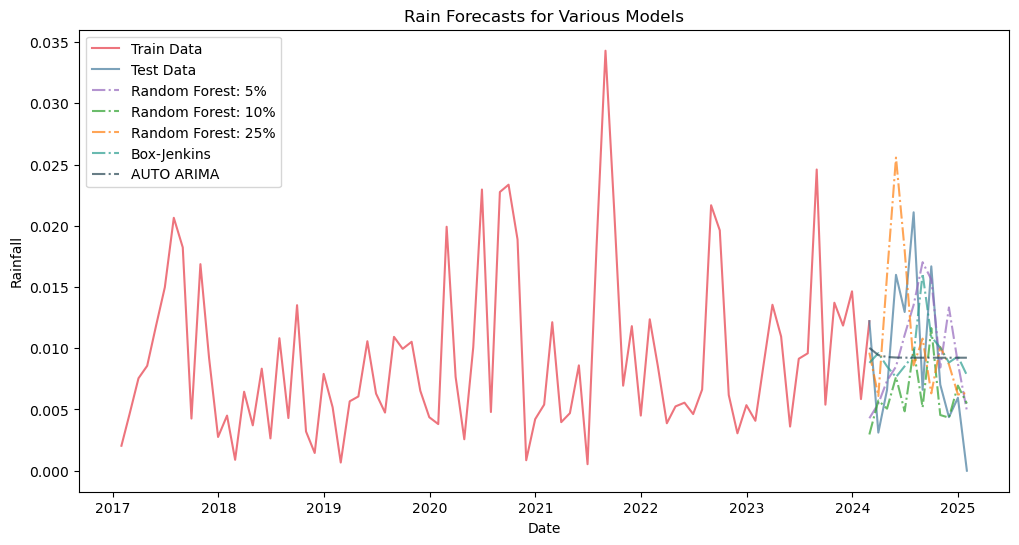

In [353]:
# Comparable Visualization 
plt.figure(figsize=(12, 6))
plt.plot(train_index, y_train, label="Train Data", color="#E63946", alpha=0.7)
plt.plot(test_index, y_test, label="Test Data", color="#457B9D", alpha=0.7)
plt.plot(test_index, rf_pred[:12], label="Random Forest: 5%", color="#9467bd", alpha=0.7,ls="-.")
plt.plot(test_index, rf_pred[13:25], label="Random Forest: 10%", color="#2ca02c", alpha=0.7,ls="-.")
plt.plot(test_index, rf_pred[52:64], label="Random Forest: 25%", color="#ff7f0e", alpha=0.7,ls="-.")
plt.plot(test_index, bj_pred, label="Box-Jenkins", color="#2A9D8F", alpha=0.7,ls="-.")
plt.plot(test_index, auto_arima_pred, label="AUTO ARIMA", color="#264653", alpha=0.7,ls="-.")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.title("Rain Forecasts for Various Models")
plt.legend()
plt.show()

The above plot summarizes the effectiveness of the Random Forest models in comparison to the other two methods. Primarily, we find that the Random Forest strikes a fair balance between the overfitting of the Box-Jenkins models and the underfitting of the Auto ARIMA. Additionally, the Random Forests which used 5% and 10% of the engineered lags appear to capture the pattern of the time series. We confirm this claim by calculating the test MSE, found below.

In [354]:
rf_five_prop_mse = mean_squared_error(rf_pred[:12], y_test)
rf_ten_prop_mse = mean_squared_error(rf_pred[13:25], y_test)
rf_twentyfive_prop_mse = mean_squared_error(rf_pred[52:64], y_test)

box_jenkins_mse = mean_squared_error(bj_pred, y_test)
auto_arima_mse = mean_squared_error(auto_arima_pred, y_test)

mse = [["Random Forest: 5%", rf_five_prop_mse], 
       ["Random Forest: 10%", rf_ten_prop_mse],
       ["Auto Arima",auto_arima_mse],
       ["Box-Jenkins", box_jenkins_mse],
       ["Random Forest: 25%", rf_twentyfive_prop_mse]]
mse_summarized = pd.DataFrame(mse, columns=["Method", "Mean Squared Error"])
mse_summarized.head()

,Method,Mean Squared Error
0,Random Forest: 5%,0.000034
1,Random Forest: 10%,0.000035
2,Auto Arima,0.000037
3,Box-Jenkins,0.000042
4,Random Forest: 25%,0.000047


From the above table, we confirm the previous intuition that two of the three Random Forest models outperform the other methods. In particular, the Random Forest model utilizing 5% of the lagged predictors had a significantly lower test MSE, reflecting its ability to properly adapt to the patterns in the data.

## 5. Conclusion

In this project, we validated the results of Tyralis and Papacharalampous that time series forecasts can be efficiently performed utilizing Random Forests trained on small proportions of lagged data. Further, we compared the prediction accuracy of the Random Forests with other contemporary methods such as Box-Jenkins and Auto ARIMA. In comparing test MSE, we found that the Random Forest models outperformed the other methods. 

Of course, our results are not without fault. In the function utilized to fit the Random Forest models, we set the variable importance cutoff to be zero. In doing this, we allowed predictors that may have had minute impact to be included in the final model, which may have contributed to overfitting. Future research may improve upon this by introducing the cutoff as a validation parameter. Further, while we were able to cross validate by fitting several Random Forest models, increased folds with larger data sets may provide more detailed insights. 

Regarding SARIMAX and Auto-Arima, there may be potential for improvement in creating identical scales, but with the added constraint of zero values in our data, complex trends mixed with noise, and potential threats to MSE inconsistency with other models in the analysis, there is potential drawbacks. Thus, in order to improve upon this accuracy, future research should yield tests on a variety of datasets, differing in length, complexity, and statistical-fitting metrics.

Overall, these results provide an exciting perspective on time series modeling. While the Box-Jenkins methodology has stood the test of time, new methods continue to emerge, offering fresh approaches to improving accuracy and adaptability in an ever-evolving field.

## References

1. Engle, R. F. (1982). Autoregressive conditional heteroscedasticity with estimates of the variance of United Kingdom inflation. Econometrica, 50(4), 987–1007. The Econometric Society. https://doi.org/10.2307/1912773.

2. Tyralis, H., & Papacharalampous, G. (2017). Variable Selection in Time Series Forecasting Using Random Forests. Algorithms, 10(4), 114. https://doi.org/10.3390/a10040114

3. Jansen, M. (2024). BGC Jena weather station dataset (2017–2024) [Dataset]. Kaggle. https://www.kaggle.com/datasets/matthewjansen/bgc-jena-weather-station-dataset-20172024.

4. Kuhn, M.; Johnson, K. Applied Predictive Modeling; Springer: New York, NY, USA, 2013. [Google Scholar]

5. Probst, P.; Boulesteix, A.L. To tune or not to tune the number of trees in random forest? arXiv 2017, arXiv:1705.05654v1. [Google Scholar]